# Multivariate pattern analysis of fMRI data to study category representation in the human brain

## In this notebook, we will work through a multivariate pattern analysis (MVPA) of one participant from Haxby et al. (2001)

The goal here is for you to learn about how to implement multivariate pattern analysis (MVPA), which attempts to determine whether distributed patterns of activity differ between conditions. In this case, we will be using machine learning to look at patterns of activaty in the visual system in response to different categories of images (e.g., faces, houses). This analysis will be done on a single participant from a landmark study:

Haxby, J. V., Gobbini, M. I., Furey, M. L., Ishai, A., Schouten, J. L., & Pietrini, P. (2001). Distributed and overlapping representations of faces and objects in ventral temporal cortex. *Science*, 293, 2425-2430. http://dx.doi.org/10.1126/science.1063736

## Why are you having us analyze fMRI data in a 200-level course?

I believe that we learn best by actually working with the content from the field. For example, if you want to learn how to paint, sure, you can read a book about painting, you can look at paintings, you might even learn from watching videos of other people painting and lectures in which experienced artists teach you how to paint. However, you are going to learn best by actually picking up a paintbrush, dipping it in the paint, and trying to paint something yourself. You will learn how to mix colors together, how much pressure to apply to the canvas, which paintbrush to use in different situations, how long to let paint dry before adding different colors, and (perhaps most importantly) you will learn from your mistakes. Simply put, you will learn a lot more by practicing (as the saying goes: "experience is the best teacher"). Moreover, these practical experiences will help you learn more from your other resources. For example, you might revisit readings or discussions to really think about *why* we use certain techniques. Similarly, to *really* understand cognitive neuroscience, I believe that we have to actually practice some cognitive neuroscience, so pick up your paintbrush and start painting some brain maps with the Python code below!

## Why are you having us analyze fMRI data in introductory cognitive neuroscience course?
I (Prof. Derek Huffman) believe that we learn best by actually working with the content from the field. For example, if you want to learn how to paint, sure, you can read a book about painting, you can look at paintings, you might even learn from watching videos of other people painting and lectures in which experienced artists teach you how to paint. However, you are going to learn best by actually picking up a paintbrush, dipping it in the paint, and trying to paint something yourself. You will learn how to mix colors together, how much pressure to apply to the canvas, which paintbrush to use in different situations, how long to let paint dry before adding different colors, and (perhaps most importantly) you will learn from your mistakes. Simply put, you will learn a lot more by practicing (as the saying goes: "experience is the best teacher"). Moreover, these practical experiences will help you learn more from your other resources. For example, you might revisit readings or discussions to really think about *why* we use certain techniques. Similarly, to *really* understand cognitive neuroscience, I believe that we have to actually practice some cognitive neuroscience, so pick up your paintbrush and start painting some brain maps with the Python code below!

## Attributions and citations for this notebook
Written by Professor Derek J. Huffman at Colby College, Waterville, ME 04901, USA (with the nilearn tutorials as a helpful starting point; Nilearn Contributors et al., 2023)

Most recent updates: 2024 JAN 17

Please keep the attribution line above as well as the citations below (update as you change the code):

Huffman, D. J. (2024). An in-depth exploration of the interplay between fMRI methods and theory in cognitive neuroscience. PsyArXiv.

Nilearn Contributors et al. (2023) nilearn. Available at: https://zenodo.org/record/8397156.

## Set things up for the analysis

### Load the relevant packages, etc.

#### For Google Colaboratory, we need to install nilearn onto the machines we are using (in the cloud).

In [1]:
pip install nilearn

#### Now we can import the relevant functions for our analysis.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from nilearn.datasets import fetch_haxby
from nilearn.image import index_img
from nilearn.image import load_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_stat_map
from nilearn.plotting import show
from nilearn.plotting import view_img

Note: the 'from nilearn.glm.first_level import FirstLevelModel' will throw a warning about nilearn.glm being experimental (AKA we are on the cutting edge haha), but we can ignore this for now.

### Gather the fMRI and event/behavioral/timing data

Next, we will want to get all of the data. Here, we will primarily rely on the fetch_haxby() function. This function will load data from a single participant (subj2) to the location we set for datapath below.

#### First, define a variable with the path to the data:

In [3]:
datapath = '.'

#### Then, use the fetch_haxby function to load the data:
Note: here we give the function the input of the datapath to let it know where to find the data.

In [4]:
subject_data = fetch_haxby(datapath)

Now we can take a look at the subject_data.

In [5]:
subject_data

{'anat': ['./haxby2001/subj2/anat.nii.gz'],
 'func': ['./haxby2001/subj2/bold.nii.gz'],
 'session_target': ['./haxby2001/subj2/labels.txt'],
 'mask_vt': ['./haxby2001/subj2/mask4_vt.nii.gz'],
 'mask_face': ['./haxby2001/subj2/mask8b_face_vt.nii.gz'],
 'mask_house': ['./haxby2001/subj2/mask8b_house_vt.nii.gz'],
 'mask_face_little': ['./haxby2001/subj2/mask8_face_vt.nii.gz'],
 'mask_house_little': ['./haxby2001/subj2/mask8_house_vt.nii.gz'],
 'mask': './haxby2001/mask.nii.gz',
 'description': 'Haxby 2001 results\n\n\nNotes\n-----\nResults from a classical fMRI study that investigated the differences between\nthe neural correlates of face versus object processing in the ventral visual\nstream. Face and object stimuli showed widely distributed and overlapping\nresponse patterns.\n\nContent\n-------\nThe "simple" dataset includes\n    :\'func\': Nifti images with bold data\n    :\'session_target\': Text file containing session data\n    :\'mask\': Nifti images with employed mask\n    :\'ses

So, what you might notice above is that for these nilearn datasets, it will essentially load strings that represent the location sof different files. You will note a few files of interest:

1) 'anat' = the anatomical / structural image of the participant's brain (T1 MRI)

2) 'func' = the functional image of the participant's brain (i.e., fMRI)

3) 'mask_vt' = a mask of the ventral temporal lobe, which is important for high-level vision

4) 'mask_face' = a mask of voxels that respond to faces (i.e., greater BOLD activity)

5) 'mask_house' = a mask of voxels that respond to houses (i.e., greater BOLD activity)

6) 'session_target' = the conditions of the dataset (here, labels = frame-by-frame indication of what was happening; chunks = the run or scan number from which that frame came... fMRI are gathered in runs, but the func file above is the concatenation or combination of all of those runs together).

In this particular case (for these nilearn datasets), the functional data can be accessed like this:

In [6]:
fmri = subject_data.func[0]

Gather the labels for each frame. This information will be necessary for knowing what was happening on each frame of the experiment. The 'labels' column contains the task condition of each frame and the 'chunks' column contains the run information. These will be key features for training and testing the classifier (see below).

To load this file, we will use the pandas function read_csv. Note: a CSV file (comma-separated values) is one way of saving data in a file where things are separated by commas. Here, the file is separated by blank spaces, hence the sep=' ' (i.e., notice the blank space between the quotes). This function will create a pandas DataFrame, which is a convenient way of storing this type of data. The DataFrame is similar to a numpy.array, but allows for data with different types in different columns. Similar to a dictionary, you can access the columns with the following syntax, e.g., tr_labels['labels']

In [7]:
tr_info = pd.read_csv(subject_data.session_target[0], sep=' ')
tr_info

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0
...,...,...
1447,rest,11
1448,rest,11
1449,rest,11
1450,rest,11


## Now we need to set up the decoder (yes, machine learning, here we come!)

In [8]:
from nilearn.decoding import Decoder
from sklearn.model_selection import LeaveOneGroupOut

Set up a function for printing the classification results.

In [9]:
def print_class_accuracy(d):
    """
    A function for printing the classification results.

    Parameters
    ----------
    d : a fit decoder
        A model that was fit via nilearn

    Returns
    -------
    Out : None
        Prints the classification accuracy and chance level
    """
    classification_accuracy = np.mean(list(d.cv_scores_.values()))
    chance_level = 1. / len(d.classes_)
    print('Classifying {}'.format(d.classes_))
    print('Classification accuracy: {:.4f} / Chance level: {}'.format(
        classification_accuracy, chance_level))
    return classification_accuracy



### We will start by looking at the classification of faces vs. houses (i.e., related to our last assignment in that employed an activation analysis).

We will start by training and testing the classifier on individual frames of fMRI data. That is, we have 121 frames per run. Each block of trials is 24 seconds long, so we will be using 9 frames from each of those blocks per condition per run. For example, here you can see the labels for scissors for the first run.

In [10]:
print(tr_info['labels'][0:20])

0         rest
1         rest
2         rest
3         rest
4         rest
5         rest
6     scissors
7     scissors
8     scissors
9     scissors
10    scissors
11    scissors
12    scissors
13    scissors
14    scissors
15        rest
16        rest
17        rest
18        rest
19        rest
Name: labels, dtype: object


In [11]:
fmri

'./haxby2001/subj2/bold.nii.gz'

In [12]:
condition_mask = tr_info['labels'].isin(['face', 'house'])
conditions_sel = tr_info['labels'][condition_mask]
run_label = tr_info['chunks'][condition_mask]
fmri_sel = index_img(fmri, condition_mask)

# Confirm that we now have 2 conditions
print(conditions_sel.unique())

['face' 'house']


### And let's see how well a classifier can distinguish trials in which participants are viewing faces vs. trials in which they are viewing houses.

#### Some notes about the classifier

1) Here, we will use a support vector machine (SVM; estimator='svc'). The SVM is commonly used in fMRI because we have a lot of features (i.e., voxels) but a limited number of trials. Some machine learning classifiers will suffer from overfitting (i.e., not generalizing well to new data) because they have a lot of free parameters. The SVM does not change its number of parameters with more features, therefore it is a good technique for fMRI. More specifically, we will be using a linear SVM, which also has benefits with respect to interpretting the results. Typically, in the case of a linear classifier, we would say that if a region can classify between categories of stimuli, then it contains information about that category. This is a bit beyond the scope of what you need to know for this class, but with a nonlinear classifier, it is more difficult to know whether or not that region "contains the representation" (vs. other downstream regions, which would be able to "read this information out").

2) We will use an approach called *cross-validation*. This is a common approach in machine learning and it is the process of partitioning your data into a "training set" and a "test set." The basic idea is that you want to train and test your classifier on indepdent data to see how well it can generalize to new examples. Our measure of interest is the generalization performance on the test data. One thing to note in the context of fMRI data is that timepoints that come from the same run are *not* independent. For example, the slow timing of the hemodynamic response function makes nearby timepoints more similar to each other (i.e., the are correlated so they are not indepdendent). In a nutshell, it is best practice to train and test the classifier on data from different runs. So, here, we employ what is called leave-one-run-out cross-validation, where we train and test our classifier on data from each run. For example, on the first iteration, we would train our classifier on the data from runs 1 to 11 and then test the classifier on the data from run 0. The next iteration we would train the classifier on runs 0 and 2 to 11 and then test it on run 1, and so forth.

In [13]:
cv = LeaveOneGroupOut()
decoder = Decoder(estimator='svc', mask=subject_data.mask_vt[0],
                  standardize='zscore_sample', screening_percentile=100,
                  scoring='accuracy', cv=cv)

# Compute the prediction accuracy for the different folds (i.e. session)
decoder.fit(fmri_sel, conditions_sel, groups=run_label)

decoder.cv_scores_['face']

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9444444444444444, 1.0, 1.0, 1.0]

What you see above is the classification accuracy for each of the validation runs. Notice that there are 12 accuracy scores here? These correspond to the 12 fMRI runs! We can calculate the average classification accuracy across all of these cross-validations, which will give an overall measure of accuracy.

In [14]:
res_trs_vtc = print_class_accuracy(decoder)

Classifying ['face' 'house']
Classification accuracy: 0.9954 / Chance level: 0.5


Well, I think that is pretty impressive! What do you think? (Remember, this is classifying single frames/images of fMRI data!)


### Now, let's combine the code above into a function so that we can re-use this framework

It is generally better to us a function rather than copying and pasting the same code all over the place. For example, there is a smaller chance of error and it is more (human) readable. So, here let's get the pieces above into a workable function.

In [15]:
def select_data(fmri_str, behavioral, conditions_arr):
    """
    Function for selecting data from a given conditions array.

    Parameters
    ----------
    fmri_str : string
        A string indicating the path and name of the fMRI data
    behavioral : pandas.DataFrame
        The behavioral conditions (here, expecting the Haxby data
        with the colums of labels and chunks)
    conditions_arr : a numpy.array
        A 1D numpy.array with the conditions to include

    Returns
    -------
    fmri_sel : the fMRI data from the selected frames
    conditions_sel : a numpy.array with the conditions labels
    run_sel : a numpy.array with the run labels
    """
    condition_mask = behavioral['labels'].isin(conditions_arr)
    conditions_sel = behavioral['labels'][condition_mask]
    run_sel = behavioral['chunks'][condition_mask]
    fmri_sel = index_img(fmri_str, condition_mask)
    return fmri_sel, conditions_sel, run_sel


def svm_loro_cv(fmri_data, behav_df, mask, conditions_arr):
    """
    Wrapper for running LORO cross validation with an SVM.

    Parameters
    ----------
    fmri_data : string
        A string indicating the path and name of the fMRI data
    behav_df : pandas.DataFrame
        The behavioral conditions (here, expecting the Haxby data
        with the columns of labels and chunks)
    conditions_arr : a numpy.array
        A 1D numpy.array with the conditions to include

    Returns
    -------
    Out : decoder
        Prints the decoding results and returns the fit nilearn decoder.
    """
    cv = LeaveOneGroupOut()
    fmri_sel, cond_sel, run_sel = select_data(fmri_data, behav_df,
                                              conditions_arr)
    decoder = Decoder(estimator='svc', mask=mask, standardize='zscore_sample',
                      screening_percentile=100, scoring='accuracy', cv=cv)
    decoder.fit(fmri_sel, cond_sel, groups=run_sel)
    avg_class_accuracy = print_class_accuracy(decoder)
    return decoder



Let's verify this gives us the same exact values as before:

In [16]:
res = svm_loro_cv(fmri, tr_info, subject_data.mask_vt[0], np.array(('face', 'house')))
res.cv_scores_['face']

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Classifying ['face' 'house']
Classification accuracy: 0.9954 / Chance level: 0.5


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9444444444444444, 1.0, 1.0, 1.0]

##### Looks like it worked!

### Now, we will want to see what happens if we restrict our analysis to specific regions of interest

#### How about looking at the house-selective voxels?

In [17]:
res = svm_loro_cv(fmri, tr_info, subject_data.mask_house[0],
                  np.array(('face', 'house')))

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Classifying ['face' 'house']
Classification accuracy: 0.9537 / Chance level: 0.5


Quite similar to the overall accuracy throughout the ventral temporal cortex.

### Now, we will want to look at other categories: how selective is the "place" area?

Here, we will look at how well this region can classify other categories of stimuli: cat vs. shoe.

In [18]:
res = svm_loro_cv(fmri, tr_info, subject_data.mask_house[0],
                  np.array(('cat', 'shoe')))

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Classifying ['cat' 'shoe']
Classification accuracy: 0.7963 / Chance level: 0.5


#### Question 1

What does it mean that the "house-selective" region can classify between different categories of visual stimuli?

## Now, let's try running the decoder on the output from a general linear model (GLM)

The steps above were fitting / testing the classifier on individual fMRI frames (i.e., TRs; the images that took place during the viewing of images from different categories). However, these could each be relatively noisy and it is generally better to run a GLM to estimate activation to different trials/stimuli/etc. Below, we will slightly modify our code from last week to gather activity in response to each category for each run.

### First, let's set up our events DataFrame so that we can fit the models (GLMs)

Gather the event timing (onsets and durations), which we will use to set up our models (see below). The difference between tr_info (above) and events (below) is that the former contains information about what is happening for each frame of the fMRI data while the latter shows the exact times (in seconds) at which different events happen.

NOTE WELL: before you run the following line of code, you need to get the events.csv file into Google Colaboratory's workspace. Here, the easiest way to do this is to click on the "Files" icon on the left side of the screen (looks like a folder), then drag and drop the events.csv file here. If you get an error on this line, then it probably means that you need to upload this file.

In [19]:
events = pd.read_csv('%s/events.csv' % datapath)
events

,trial_type,run,onset,duration
0,scissors,0,12.0,24.0
1,face,0,48.0,24.0
2,cat,0,84.0,24.0
3,shoe,0,120.0,24.0
4,house,0,156.0,24.0
...,...,...,...,...
91,scrambledpix,11,120.0,24.0
92,face,11,156.0,24.0
93,shoe,11,192.0,24.0
94,cat,11,228.0,24.0


#### Extract the fMRI and event files into a list where the elements are the runs.

Now, we will want to separate the data based on the runs. Here, we will load the data into lists in which each element contains the data for one fMRI run.

Note: hopefully the [x for x in y] type of syntax is familar from the earlier homeworks/readings, but this is basically a way that you can populate a list with a for loop in a single line of code. Here, it will loop over all of the runs and separate the data into a list. We will end up with lists with 12 elements: fmri_runs will have 12 runs of fMRI data and events_runs will have 12 runs of events/behavioral/timing data.

In [20]:
run_nums = np.unique(events['run'])

fmri_runs = [index_img(fmri, tr_info['chunks'] == run_i) for run_i in run_nums]
events_runs = [events[events['run'] == run_i] for run_i in run_nums]

### Modify our code slightly from last week to output z-maps.

These files will create one z-score map for each category for each run. That is, instead of having 9 examples of each category per run (as above), we will end up with 1 example of each category per run.

In [21]:
drift_model = 'polynomial'
poly_drift_order = 3
high_pass = 0.01
mask_img = subject_data.mask_vt[0]

(40, 64, 64, 121)
     trial_type  run  onset  duration
0      scissors    0   12.0      24.0
1          face    0   48.0      24.0
2           cat    0   84.0      24.0
3          shoe    0  120.0      24.0
4         house    0  156.0      24.0
5  scrambledpix    0  192.0      24.0
6        bottle    0  228.0      24.0
7         chair    0  264.0      24.0


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(


bottle
cat
chair
face
house
scissors
scrambledpix
shoe


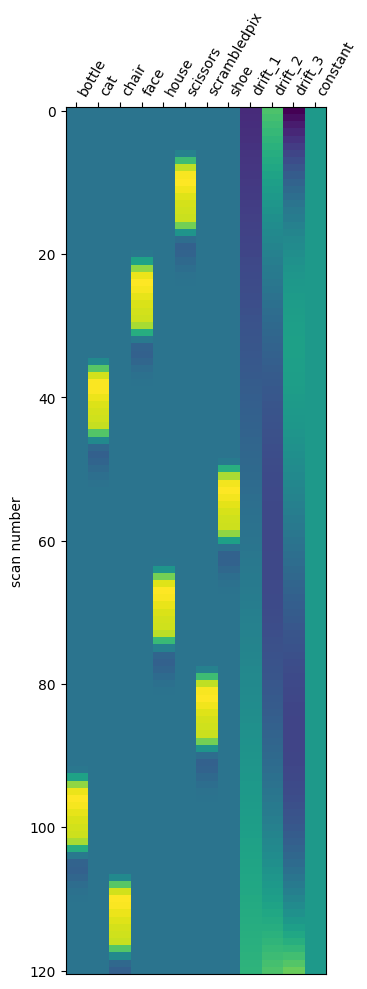

(40, 64, 64, 121)
      trial_type  run  onset  duration
8           face    1   12.0      24.0
9   scrambledpix    1   48.0      24.0
10      scissors    1   84.0      24.0
11          shoe    1  120.0      24.0
12        bottle    1  156.0      24.0
13           cat    1  192.0      24.0
14         chair    1  228.0      24.0
15         house    1  264.0      24.0


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(


bottle
cat
chair
face
house
scissors
scrambledpix
shoe


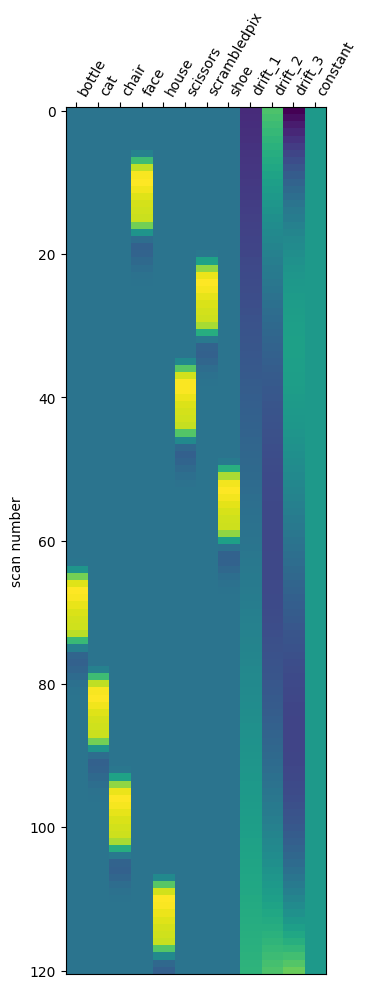

(40, 64, 64, 121)
      trial_type  run  onset  duration
16          face    2   12.0      24.0
17         chair    2   48.0      24.0
18           cat    2   84.0      24.0
19         house    2  120.0      24.0
20  scrambledpix    2  156.0      24.0
21          shoe    2  192.0      24.0
22        bottle    2  228.0      24.0
23      scissors    2  264.0      24.0


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(


bottle
cat
chair
face
house
scissors
scrambledpix
shoe


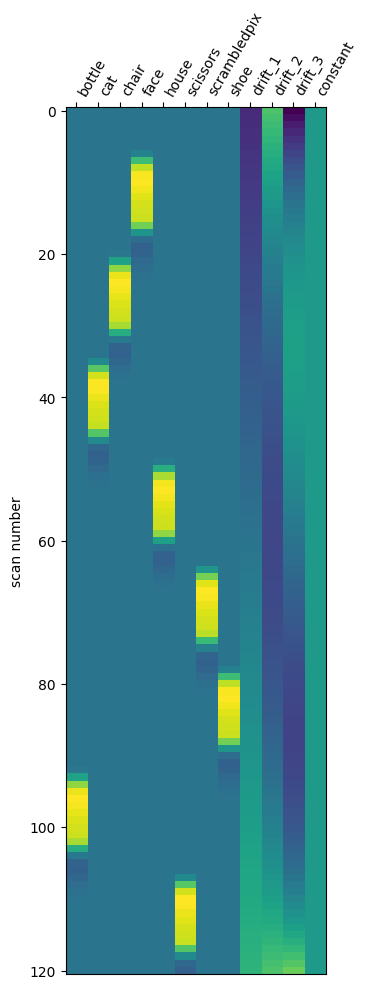

(40, 64, 64, 121)
      trial_type  run  onset  duration
24          shoe    3   12.0      24.0
25         house    3   48.0      24.0
26         chair    3   84.0      24.0
27           cat    3  120.0      24.0
28          face    3  156.0      24.0
29  scrambledpix    3  192.0      24.0
30        bottle    3  228.0      24.0
31      scissors    3  264.0      24.0


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(


bottle
cat
chair
face
house
scissors
scrambledpix
shoe


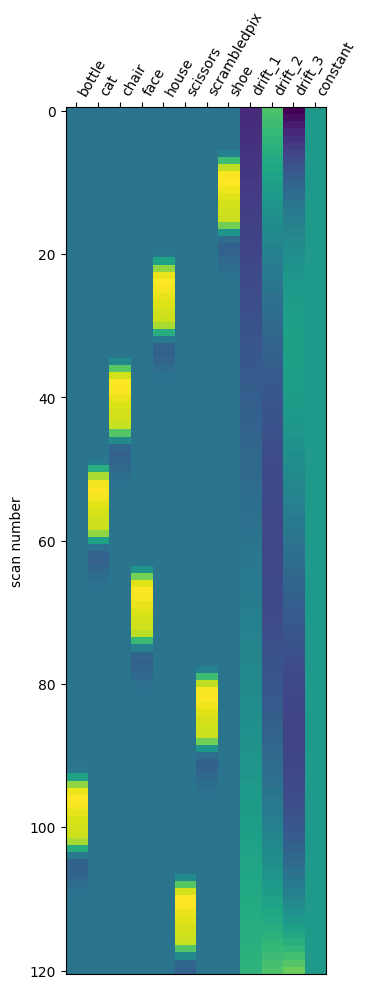

(40, 64, 64, 121)
      trial_type  run  onset  duration
32          face    4   12.0      24.0
33           cat    4   48.0      24.0
34          shoe    4   84.0      24.0
35         chair    4  120.0      24.0
36      scissors    4  156.0      24.0
37        bottle    4  192.0      24.0
38         house    4  228.0      24.0
39  scrambledpix    4  264.0      24.0


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(


bottle
cat
chair
face
house
scissors
scrambledpix
shoe


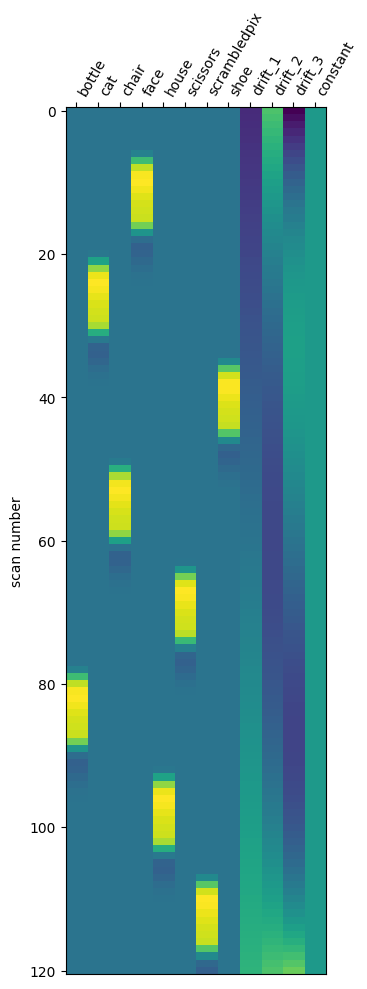

(40, 64, 64, 121)
      trial_type  run  onset  duration
40           cat    5   12.0      24.0
41  scrambledpix    5   48.0      24.0
42      scissors    5   84.0      24.0
43         chair    5  120.0      24.0
44        bottle    5  156.0      24.0
45          shoe    5  192.0      24.0
46          face    5  228.0      24.0
47         house    5  264.0      24.0


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(


bottle
cat
chair
face
house
scissors
scrambledpix
shoe


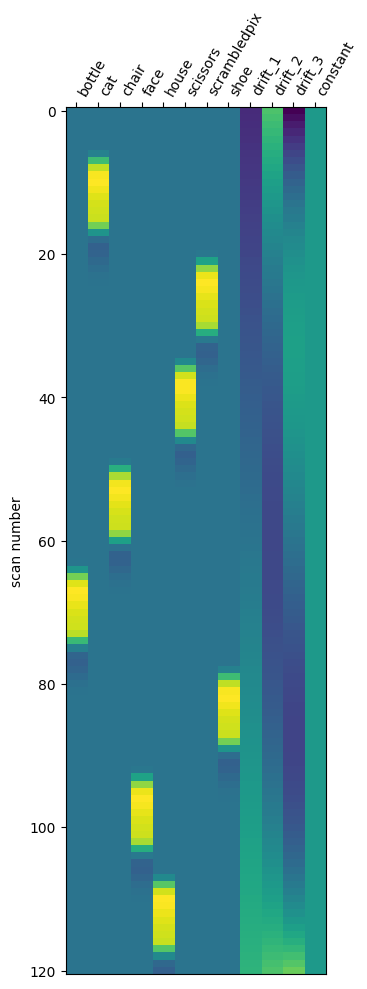

(40, 64, 64, 121)
      trial_type  run  onset  duration
48         house    6   12.0      24.0
49      scissors    6   48.0      24.0
50        bottle    6   84.0      24.0
51          face    6  120.0      24.0
52         chair    6  156.0      24.0
53          shoe    6  192.0      24.0
54           cat    6  228.0      24.0
55  scrambledpix    6  264.0      24.0


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(


bottle
cat
chair
face
house
scissors
scrambledpix
shoe


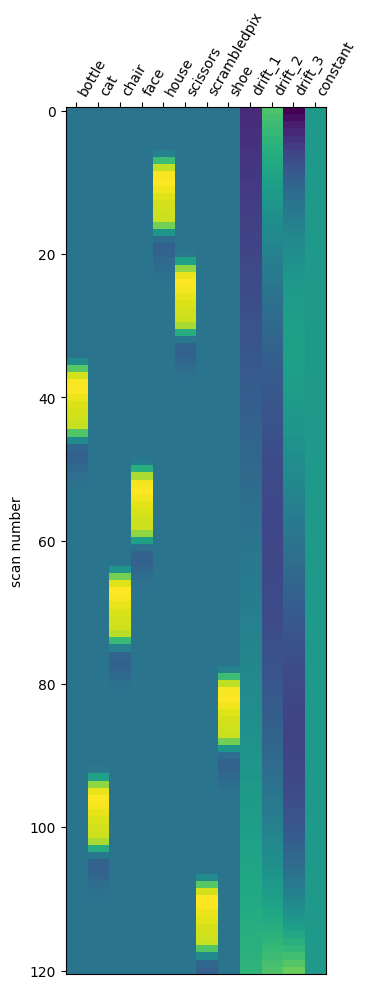

(40, 64, 64, 121)
      trial_type  run  onset  duration
56          face    7   12.0      24.0
57         chair    7   48.0      24.0
58      scissors    7   84.0      24.0
59          shoe    7  120.0      24.0
60  scrambledpix    7  156.0      24.0
61         house    7  192.0      24.0
62           cat    7  228.0      24.0
63        bottle    7  264.0      24.0


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(


bottle
cat
chair
face
house
scissors
scrambledpix
shoe


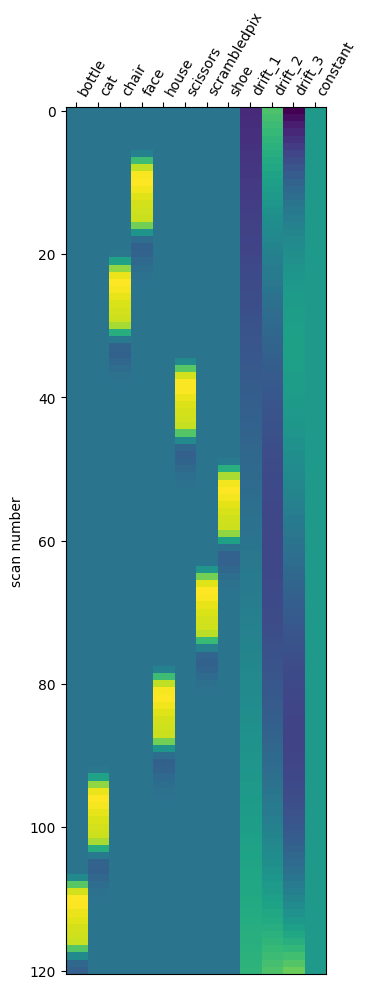

(40, 64, 64, 121)
      trial_type  run  onset  duration
64          face    8   12.0      24.0
65           cat    8   48.0      24.0
66  scrambledpix    8   84.0      24.0
67         house    8  120.0      24.0
68      scissors    8  156.0      24.0
69         chair    8  192.0      24.0
70          shoe    8  228.0      24.0
71        bottle    8  264.0      24.0


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(


bottle
cat
chair
face
house
scissors
scrambledpix
shoe


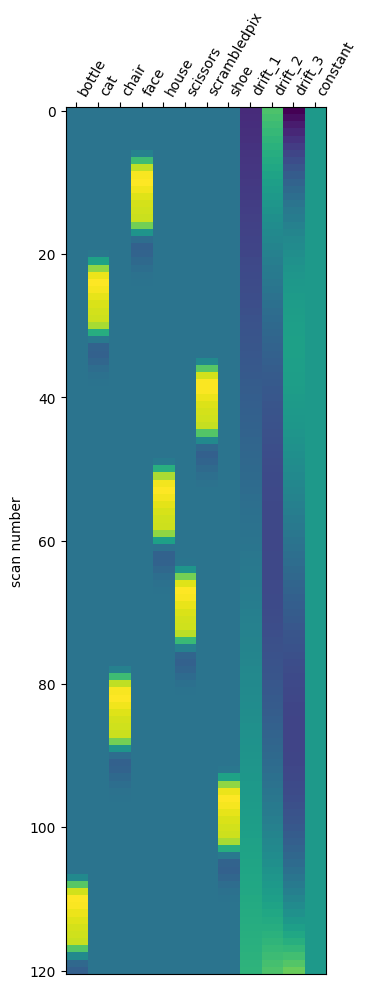

(40, 64, 64, 121)
      trial_type  run  onset  duration
72         house    9   12.0      24.0
73  scrambledpix    9   48.0      24.0
74          face    9   84.0      24.0
75          shoe    9  120.0      24.0
76         chair    9  156.0      24.0
77           cat    9  192.0      24.0
78        bottle    9  228.0      24.0
79      scissors    9  264.0      24.0


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(


bottle
cat
chair
face
house
scissors
scrambledpix
shoe


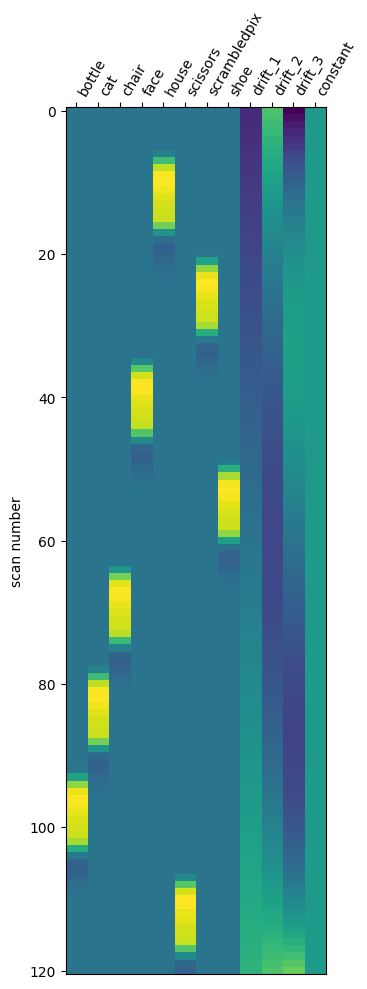

(40, 64, 64, 121)
      trial_type  run  onset  duration
80           cat   10   12.0      24.0
81  scrambledpix   10   48.0      24.0
82         chair   10   84.0      24.0
83        bottle   10  120.0      24.0
84          shoe   10  156.0      24.0
85         house   10  192.0      24.0
86          face   10  228.0      24.0
87      scissors   10  264.0      24.0


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(


bottle
cat
chair
face
house
scissors
scrambledpix
shoe


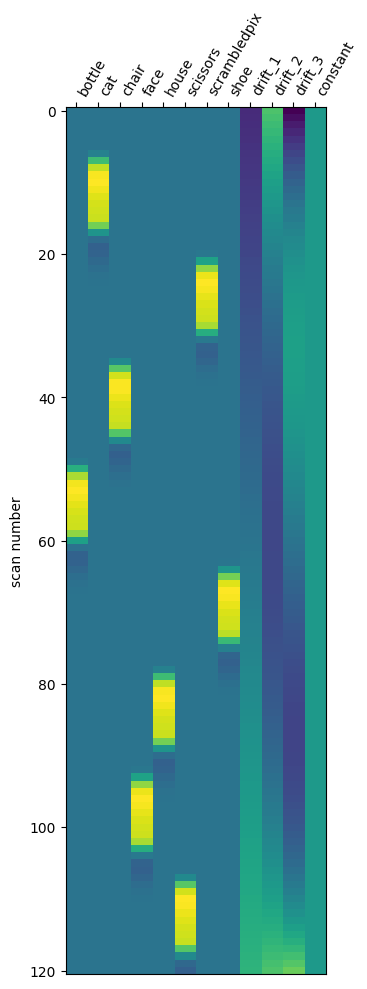

(40, 64, 64, 121)
      trial_type  run  onset  duration
88        bottle   11   12.0      24.0
89         house   11   48.0      24.0
90         chair   11   84.0      24.0
91  scrambledpix   11  120.0      24.0
92          face   11  156.0      24.0
93          shoe   11  192.0      24.0
94           cat   11  228.0      24.0
95      scissors   11  264.0      24.0


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:166: UserWarning: The following unexpected columns in events data will be ignored: run
  warnings.warn(


bottle
cat
chair
face
house
scissors
scrambledpix
shoe


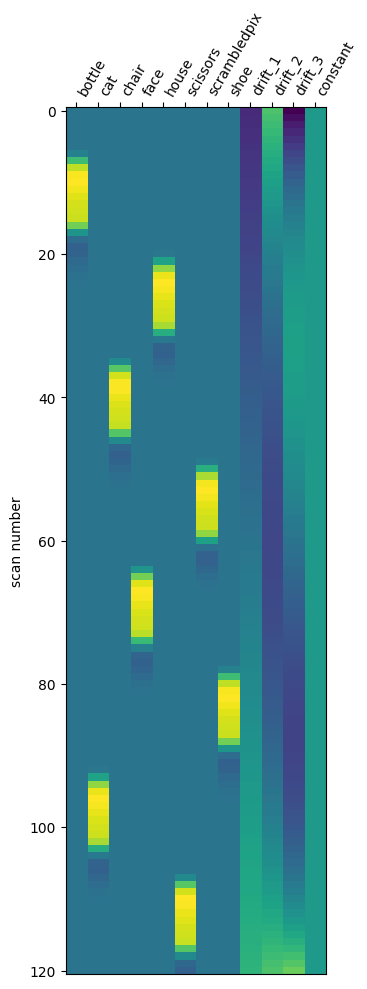

In [22]:
# set up empty lists in which we can store our information of interest --------
z_maps = []
task_label_glm = []
run_label_glm = []

# set up an array with all of the unique conditions (for looping below) -------
task_unique = np.unique(events['trial_type'])

# loop over all of the runs to run the GLM ------------------------------------
for run_i in np.arange(len(fmri_runs)):
    fmri_glm = FirstLevelModel(t_r=2.5, noise_model='ar1', standardize=False,
                               hrf_model='spm', drift_model=drift_model,
                               drift_order=poly_drift_order,
                               high_pass=high_pass, mask_img=mask_img)
    print(fmri_runs[run_i].shape)
    print(events_runs[run_i])
    fmri_glm = fmri_glm.fit(fmri_runs[run_i], events_runs[run_i])
    # extract z-statistics for each condition; i.e., our GLM-based patterns ---
    # and append the z-statistics, task labels, and run labels ----------------
    for condition_i in task_unique:
        print(condition_i)
        z_maps.append(fmri_glm.compute_contrast(condition_i))
        task_label_glm.append(condition_i)
        run_label_glm.append(run_i)
    plot_design_matrix(fmri_glm.design_matrices_[0])
    plt.show()

# convert the lists to numpy arrays -------------------------------------------
z_maps = np.array(z_maps)
task_label_glm = np.array(task_label_glm)
run_label_glm = np.array(run_label_glm)

### Here are a couple of functions that will help for the classification of different categories with different masks.

In [23]:
def run_class_zmap(z_maps_arg, task_label_arg, run_label_arg,
                   mask, categories):
    """
    Run classification analysis on z-maps with categories.

    Note: here, I am omitting z-scoring because we are already using
    the z-maps, thus we are effectively standardized within each run.

    Parameters
    ----------
    z_maps_arg : numpy.array with z-score maps
        A numpy.array with z-score maps from a GLM
    task_label_arg : a numpy.array of strings
        The task labels that correspond to the z-score maps
    run_label_arg : a numpy.array of int
        The run labels that correspond to the z-score maps
    mask : string
        A string indicating the path and name of the mask
    categories: numpy.array
        A numpy.array of the categories to include in the classification

    Returns
    -------
    Out : None
        Does not return anything but prints the results of decoding.
    """
    sel_mask = [x in categories for x in task_label_arg]
    z_maps_sel = z_maps_arg[sel_mask]
    task_sel = task_label_arg[sel_mask]
    run_sel = run_label_arg[sel_mask]
    decoder = Decoder(estimator='svc', mask=mask, standardize=False,
                      screening_percentile=100, cv=LeaveOneGroupOut())
    decoder.fit(z_maps_sel, task_sel, groups=run_sel)
    avg_acc = print_class_accuracy(decoder)
    return avg_acc


### Then, let's run the classification for faces vs. houses in VT with these z-score maps (from the GLMs)

In [24]:
res_FvH_vtc = run_class_zmap(z_maps, task_label_glm, run_label_glm,
                             mask=subject_data.mask_vt[0],
                             categories=np.array(['face', 'house']))

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Classifying ['face' 'house']
Classification accuracy: 1.0000 / Chance level: 0.5


Okay, 100% now!

### What about classification in VT for other CATegories?

In [25]:
res_CvS_vtc = run_class_zmap(z_maps, task_label_glm, run_label_glm,
                             mask=subject_data.mask_vt[0],
                             categories=np.array(['cat', 'shoe']))

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Classifying ['cat' 'shoe']
Classification accuracy: 1.0000 / Chance level: 0.5


This is also looking purrfect! ;)

### Let's try the same process for the "house" selective voxels

#### Faces vs. houses

In [26]:
res_FvH_ppa = run_class_zmap(z_maps, task_label_glm, run_label_glm,
                             mask=subject_data.mask_house[0],
                             categories=np.array(['face', 'house']))

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Classifying ['face' 'house']
Classification accuracy: 1.0000 / Chance level: 0.5


#### Cats vs. shoes

In [27]:
res_CvS_ppa = run_class_zmap(z_maps, task_label_glm, run_label_glm,
                             mask=subject_data.mask_house[0],
                             categories=np.array(['cat', 'shoe']))

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Classifying ['cat' 'shoe']
Classification accuracy: 1.0000 / Chance level: 0.5


### Let's try the same process for the "face" selective voxels

#### Faces vs. houses

In [28]:
res_FvH_ffa = run_class_zmap(z_maps, task_label_glm, run_label_glm,
                             mask=subject_data.mask_face[0],
                             categories=np.array(['face', 'house']))

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/decoding/decoder.py:756: UserWarning: After clustering and screening, the decoding model will be trained only on 30 features. Consider raising clustering_percentile or screening_percentile parameters.
  warnings.warn(


Classifying ['face' 'house']
Classification accuracy: 0.9167 / Chance level: 0.5


#### Cats vs. shoes

In [29]:
res_CvS_ffa = run_class_zmap(z_maps, task_label_glm, run_label_glm,
                             mask=subject_data.mask_face[0],
                             categories=np.array(['cat', 'shoe']))

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/decoding/decoder.py:756: UserWarning: After clustering and screening, the decoding model will be trained only on 30 features. Consider raising clustering_percentile or screening_percentile parameters.
  warnings.warn(


Classifying ['cat' 'shoe']
Classification accuracy: 1.0000 / Chance level: 0.5


### Let's create a figure with the results for the classification of Faces vs. "Places" and Cats vs. Shoes in the ventral temporal cortex as well as the face-selective voxels and the "place"-selective voxels

#### First, we need to get the data into a pandas DataFrame

In [30]:
# get all of the classification accuracy into a numpy array -------------------
# here, we will multiply by 100 since percent accuracy is easier for plots ----
acc_all_data = np.array((res_FvH_vtc, res_FvH_ffa, res_FvH_ppa,
                         res_CvS_vtc, res_CvS_ffa, res_CvS_ppa)) * 100

# create a numpy array with the classification categories ---------------------
classification_categories = np.append(np.repeat("Faces vs. Places", 3),
                                      np.repeat("Cats vs. Shoes", 3))

# create a numpy array with the region of interest information (i.e., mask) ---
region_of_interest = np.array(("VTC", "FFA", "PPA", "VTC", "FFA", "PPA"))

# place it all into a DataFrame for easy plotting in seaborn ------------------
df = pd.DataFrame({"Classification accuracy" : acc_all_data,
                   "Classification categories" : classification_categories,
                   "Region of interest" : region_of_interest})

In [31]:
df

,Classification accuracy,Classification categories,Region of interest
0,100.000000,Faces vs. Places,VTC
1,91.666667,Faces vs. Places,FFA
2,100.000000,Faces vs. Places,PPA
3,100.000000,Cats vs. Shoes,VTC
4,100.000000,Cats vs. Shoes,FFA
5,100.000000,Cats vs. Shoes,PPA


#### Next, we can plot the data using seaborn

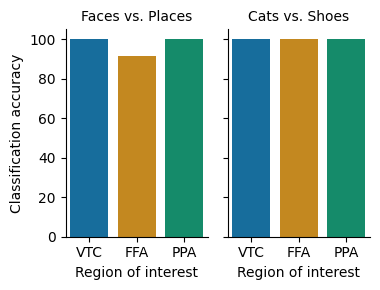

In [32]:
g = sns.FacetGrid(df, col="Classification categories", hue="Region of interest",
                  palette="colorblind", aspect=0.65)
g.map(sns.barplot, "Region of interest", "Classification accuracy",
      order=["VTC", "FFA", "PPA"])
g.set_titles('{col_name}')
plt.savefig("classification_glm.pdf", bbox_inches="tight")

You can download a PDF of these results by clicking on the "Files" icon on the left side of this page (looks like a folder) and then download the new file: classification_glm.pdf.

#### Question 2

How do the results from this GLM-based approach compare to the single-TR based approach above? For example, is classification accuracy generally better/worse/the same?

#### Question 3

If there were differences between single TRs and the GLM, what could potentially cause these differences?

#### Question 4

How do you interpret these findings? How do these results fit in with the activation analysis from last week? For example, similar to Question 1 above, do these results cause you to reinterpret your conclusions from last week (e.g., about potential modularity / specialization)? Why or why not? Please also discuss which theory or theories activation analysis vs. MVPA allow us to test.